# Coursework 1

## Part 2. Calculate estimated amount of work for teachers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
DATA_PATH = "./Data"

In [3]:
df_dict = {}

for file_ in os.listdir(DATA_PATH):
    df_dict[file_] = pd.read_csv(os.path.join(DATA_PATH, file_))
    
df_dict["progresses.csv"].columns = ["progress_id", "student_id", "course_id"]

df_dict["students.csv"].columns = ['id_', 'student_id', 'city', 'birthday']
df_dict["students.csv"]["birthday"] = pd.to_datetime(df_dict["students.csv"]["birthday"], errors="coerce")

df_dict["courses.csv"].columns = ["index", "course_id", "course_title", "course_field"]
df_dict["courses.csv"].set_index("index", inplace=True)

dataset = pd.merge(left=df_dict["progresses.csv"],
                   right=df_dict["progress_phases.csv"],
                   on="progress_id",
                   how="outer")

dataset = pd.merge(left=dataset,
                   right=df_dict["courses.csv"],
                   on="course_id",
                   how="outer")

dataset = pd.merge(left=dataset,
                   right=df_dict["course_contents.csv"],
                   on=["course_id", "lesson_number", "module_number"],
                   how="outer")

dataset["start_date"] = (
    pd.to_datetime(dataset["start_date"], errors="coerce", utc=False)
    .dt.tz_localize(None)
    )

dataset["finish_date"] = (
    pd.to_datetime(dataset["finish_date"], errors="coerce", utc=False)
    .dt.tz_localize(None)
    )

dset_students = df_dict["students.csv"].copy(deep=True)
dset_students["age_years"] = (np.datetime64(str(2022)) - dset_students["birthday"]).astype("timedelta64[Y]")
#dset_students["student_age"] = dset_students["student_age"].astype("timedelta64[Y]")

print("Main dataset:", dataset.dtypes, dataset.columns, sep="\n", end="\n\n")
print("Student dataset:", dset_students.dtypes, dset_students.columns, sep="\n")

Main dataset:
progress_id              object
student_id               object
course_id                object
module_number           float64
lesson_number           float64
status                   object
start_date       datetime64[ns]
finish_date      datetime64[ns]
course_title             object
course_field             object
module_title             object
lesson_title             object
lesson_token             object
is_video                 object
is_homework              object
dtype: object
Index(['progress_id', 'student_id', 'course_id', 'module_number',
       'lesson_number', 'status', 'start_date', 'finish_date', 'course_title',
       'course_field', 'module_title', 'lesson_title', 'lesson_token',
       'is_video', 'is_homework'],
      dtype='object')

Student dataset:
id_                    int64
student_id            object
city                  object
birthday      datetime64[ns]
age_years            float64
dtype: object
Index(['id_', 'student_id', 'city', 'birth

### Monthly growth of students in each course

From March 2016 until July 2019, included

Consider first homework start date as a course start 

In [4]:
per_range = pd.period_range("2016-03", "2019-07", freq="M")
per_range

PeriodIndex(['2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
             '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
             '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
             '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
             '2019-03', '2019-04', '2019-05', '2019-06', '2019-07'],
            dtype='period[M]')

In [7]:
data_agg = pd.DataFrame(index=per_range)

for name, gr_ in dataset.groupby("course_title"):
    
    # init new column
    data_agg[name] = 0
    
    for period in per_range:
        data_agg.loc[period, name] = (
            (
                period.start_time <= gr_["start_date"]) & (
                period.end_time >= gr_["start_date"]
            )
        ).sum()

data_agg.tail()

,Excel Базовый,Java-разработчик,Java-разработчик c нуля,JavaScript с нуля,PHP-разработчик с 0 до PRO. Часть 1,SMM-маркетолог от А до Я,UX-дизайн,Анимация интерфейсов,Веб-вёрстка для начинающих 2.0,Веб-дизайн PRO 2.0,Веб-дизайн Базовый,Веб-дизайн с нуля 2.0,Веб-разработчик,Интернет-маркетолог от Ingate,Руководитель digital-проектов
2019-03,1974,3182,1027,2151,472,864,1207,426,2764,1764,219,7868,89,7090,1348
2019-04,1732,1515,2728,1961,431,972,990,223,2401,1574,249,7226,62,6282,921
2019-05,1721,892,2895,2075,510,1086,994,212,2336,1860,153,5863,83,5574,986
2019-06,1589,511,4411,2019,367,1386,1301,256,2322,1876,107,5738,84,6475,822
2019-07,1063,279,3240,1002,380,1249,694,136,1464,1164,105,3382,39,4037,610


### Growth of students plots

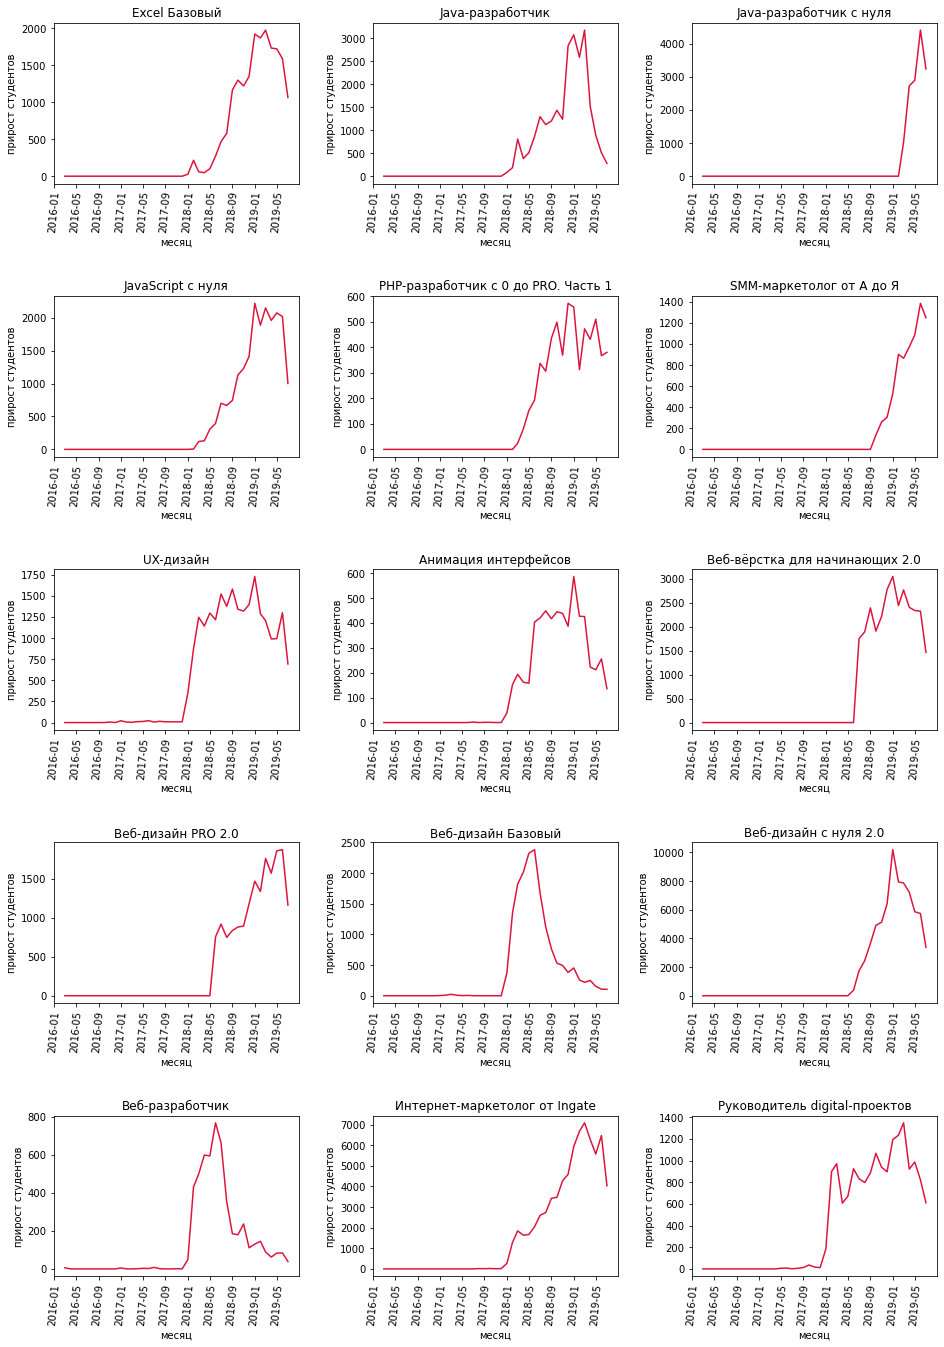

In [8]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, axs = plt.subplots(5, 3, figsize=(13, 18))

# share Y-axis option for comparsion
#fig, axs = plt.subplots(5, 3, figsize=(14, 18), sharey=True)

fig.tight_layout()
fig.subplots_adjust(hspace=0.7, wspace=0.3)


col_index = 0

for ax_row in axs:
    for ax in ax_row:
        ser = data_agg.iloc[:, col_index]
        ser.index = ser.index.to_timestamp()
        
        ax.plot(ser, color="crimson")
        ax.tick_params(axis="x", labelrotation=85.0)
        ax.set_title(ser.name)
        ax.set_xlabel("месяц")
        ax.set_ylabel("прирост студентов")
        
        col_index += 1
        

plt.show()

### Growth of students on one plot

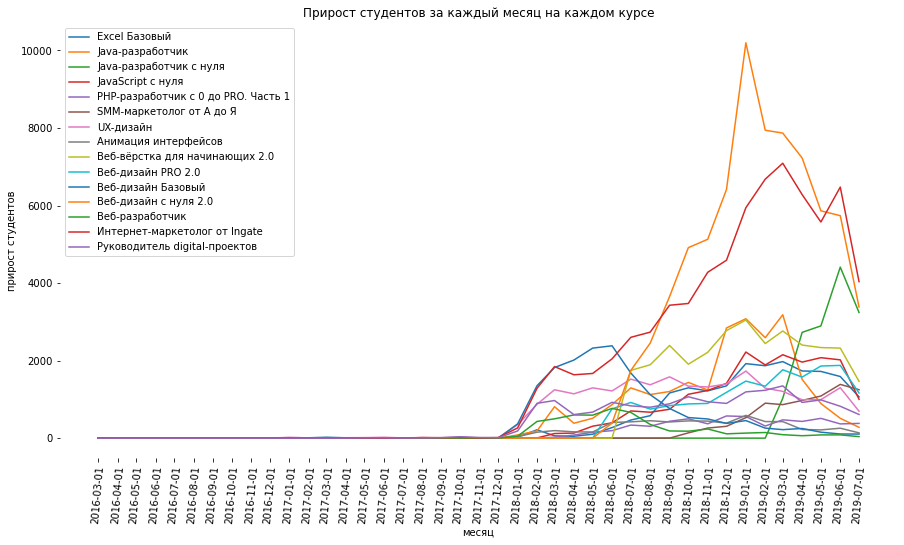

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))

for col_name in data_agg:
    ser = data_agg[col_name].copy(deep=True)
    ser.index = ser.index.to_timestamp()
    ax.plot(ser, label=col_name)

ax.set_xticks(ser.index)
ax.tick_params(axis="x", labelrotation=85.0)
ax.set_title("Прирост студентов за каждый месяц на каждом курсе")
ax.set_xlabel("месяц")
ax.set_ylabel("прирост студентов")
ax.legend()
ax.set_frame_on(False)

plt.show()

### Number of homework progresses in each month

3 cases:
* start date and finish date are in the same period
* start date in one period and finish date in next period
* start date in one period, some periods in between and finish date in the last period

In [10]:
# example

(
    (dataset["start_date"] <= per_range[0].start_time) &
    (dataset["finish_date"] >= per_range[0].start_time)
) | (
    (dataset["start_date"] <= per_range[0].end_time) &
    (dataset["finish_date"] >= per_range[0].end_time)
)

0         False
1         False
2         False
3         False
4         False
          ...  
350678    False
350679    False
350680    False
350681    False
350682    False
Length: 350683, dtype: bool

In [11]:
data_agg = pd.DataFrame()

for name, gr in dataset.groupby("course_title"):

    temp_df = pd.DataFrame()

    for per in per_range:
        temp_df[per] = (
            (
                (gr["start_date"] <= per.start_time) &
                (gr["finish_date"] >= per.start_time)
            ) | (
                (gr["start_date"] <= per.end_time) &
                (gr["finish_date"] >= per.end_time)
            )
        )

    data_agg[name] = temp_df.sum()
    
data_agg

,Excel Базовый,Java-разработчик,Java-разработчик c нуля,JavaScript с нуля,PHP-разработчик с 0 до PRO. Часть 1,SMM-маркетолог от А до Я,UX-дизайн,Анимация интерфейсов,Веб-вёрстка для начинающих 2.0,Веб-дизайн PRO 2.0,Веб-дизайн Базовый,Веб-дизайн с нуля 2.0,Веб-разработчик,Интернет-маркетолог от Ingate,Руководитель digital-проектов
2016-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-11,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
2016-12,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
